# Pivot Tables

- A pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.

- For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Pivot Tables by Hand

- Start by grouping according to gender, survival status, or some combination thereof. You might be tempted to apply a ``GroupBy`` operation.

In [3]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


- If we look at survival by both sex & class, we might: *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index:

In [4]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


- Two-dimensional ``GroupBy`` operations are common enough that Pandas includes a convenience routine, ``pivot_table``.

### Pivot Table Syntax
- Here is the equivalent to the preceding operation using the ``pivot_table``.

In [5]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


### Multi-level pivot tables

- Pivot tables can be specified with multiple levels, and via a number of options. For example, we might be interested in looking at age as a third dimension. We'll bin the age using the __``pd.cut``__ function:

In [6]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

- Repeat the strategy when working with columns; let's add info on the fare paid using __``pd.qcut``__ to automatically compute quantiles:

In [8]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308  

### Additional pivot table options

The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

- Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

- ``aggfunc`` controls what type of aggregation is used (mean = default).
The aggregation can be a string (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.). It can also be specified as a dictionary mapping a column to any of the above desired options.

In [9]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

- Notice that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

- Find the totals for each grouping via the ``margins`` keyword:

In [10]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


- This displays class-agnostic survival rate by gender, gender-agnostic survival rate by class, and overall survival rate of 38%. The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

### Example: Birthrate Data

- Download US birth data from the Centers for Disease Control (CDC) at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv.

In [11]:
# shell command to download the data:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [12]:
births = pd.read_csv('data/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1,F,4046
1,1969,1,1,M,4440
2,1969,1,2,F,4454
3,1969,1,2,M,4548
4,1969,1,3,F,4548


- Add a decade column & review male and female births as a function of decade.

In [13]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


- Male births outnumber female births in every decade. Use the built-in plotting tools in Pandas to visualize the total number of births by year.

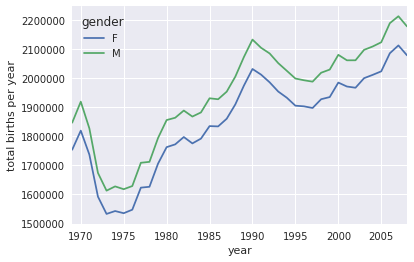

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

- Iit appears that over the past 50 years male births have outnumbered female births by around 5%.

### Further data exploration

- There are more interesting features we can pull out of this dataset using the Pandas tools. Start by cleaning the data: removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th). One easy way to remove these all at once is to cut outliers; we'll do this via a sigma-clipping operation:

In [15]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

- This final line is an estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution.

- Now we can use the ``query()`` method to filter out rows with births outside these values:

In [16]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

- Next we set the ``day`` column to integers; previously it had been a string because some columns in the dataset contained the value ``'null'``:

In [17]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

- Combine the day, month, and year to create a Date index. This allows us to quickly compute the weekday corresponding to each row:

In [18]:
births.index = pd.to_datetime(
    10000 * births.year + 
    100 * births.month + 
    births.day, 
    format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

- Using this we can plot births by weekday for several decades:

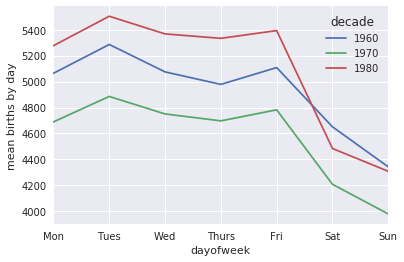

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

- Apparently births are slightly less common on weekends. Note the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

- Plot the mean number of births by the day of the *year*. First group the data by month and day separately:

In [20]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

- The result is a multi-index over months and days. Convert the indexes into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [ ]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

- We now have a time series reflecting the average number of births by date of the year. ``plot`` method to plot the data. It reveals some interesting trends:

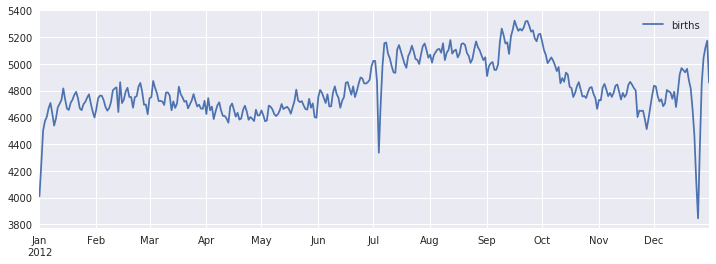

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);